# An experimental ordinary differential equations solver using neural networks
### by Georges Tod, ULB, February 2020

based on Raissi, Maziar, Paris Perdikaris, and George Em Karniadakis. "Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations." arXiv preprint arXiv:1711.10561 (2017).




This notebook shows how to solve the simple pendulum equation with some friction,

$$
\ddot{\theta} + \alpha \cdot \dot{\theta} + \sin{\theta} = 0
$$

where $\theta$ is the angle of the pendulum and with $\alpha = 0.1$.

Most of the work happens in the attached file: _DE_solver.py_

**REMARK: tensorflow 1.xx is required (not 2.xx)**

In [6]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import tensorflow as tf
import scipy.io
import DE_solver

#### some useful functions


In [2]:
def num_weights(layers):
    n = 0 
    l = len(layers)-1
    for i in range(l):
        n = layers[i]*layers[i+1] + n
    return n

def num_biases(layers):
    n = 0
    l = len(layers)
    for i in range(1,l):
        n = layers[i] + n
    return n

def num_params(layers):
    return num_biases(layers)+num_weights(layers)

# parameters

In [3]:
### initial conditions ###
theta0 = 3.   #  angle
omega0 = -1  #  angular velocity

### collocation points ###
tStop = 30.
NN_archi = [[1,5,5,1]]

l_iterations = range(5)
l_limit_act = [1.57] # limits of the activation functions
inputs=[]
res=[]
num_comp = len(NN_archi)*len(l_limit_act)*len(l_iterations)
num_comp



5

# computations

In [4]:

count = 0
lN=0
### neural net layers ###
for layers in NN_archi:
    for limit_act in l_limit_act:
        for iteration in l_iterations:
            
            count = count + 1
            print(round(count/num_comp,1))

            n_params = num_params(layers)
            t = np.linspace(0., tStop, num = 10*num_params(layers))

            inputs.append([layers,n_params,limit_act,iteration])
            
            ### create the model ###
            # preparing parameters for the model
            t_b_train = np.array([[0]])
            w_b_train = np.array([[theta0]])
            t_f_train = np.reshape(t,(-1,1))
            N_train = int(len(t)) 
            lb = np.array([np.min(t)])      # time domain bounds                         
            ub = np.array([np.max(t)]) 

            model = DE_solver.DE_solver(t_b_train, w_b_train,
                                         t_f_train,layers,
                                          lb, ub, N_train,limit_act)

            ### train the neural net ###
            tic = time.time()
            model.sol_train(N_iter=0)
            elapsed = time.time() - tic

            print('Computed solution in: ' + str(np.around(elapsed,2)) + ' seconds')

            # storing results
            w_pred = model.sol_predict(t_f_train)
            res.append([t, w_pred,np.around(elapsed,2)])
            del model # cleaning...
            
    lN +=1

0.2


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.027422
  Number of iterations: 926
  Number of functions evaluations: 1127
Computed solution in: 5.81 seconds
0.4
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.006056
  Number of iterations: 654
  Number of functions evaluations: 816
Computed solution in: 4.05 seconds
0.6
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective func

# plotting results

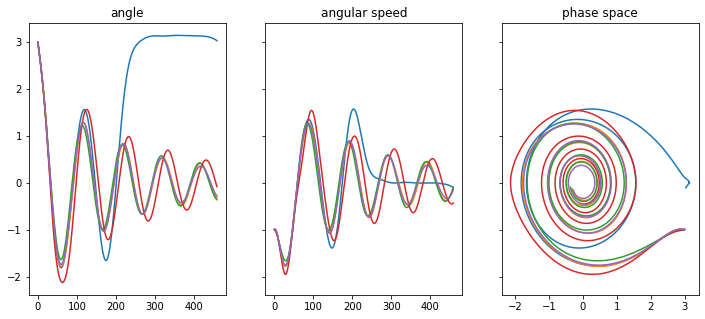

In [5]:
fig, ax = plt.subplots(1,3,sharey='row',figsize=(12, 5))

for i in range(5):

    ax[0].plot(res[i][1][0])   # 0: theta, 1: theta dot, 2: loss
    ax[1].plot(res[i][1][1])   # 0: theta, 1: theta dot, 2: loss
    ax[2].plot(res[i][1][0],res[i][1][1])   # 0: theta, 1: theta dot, 2: loss

ax[0].set_title('angle')
ax[1].set_title('angular speed')
ax[2].set_title('phase space');


At $t=0$, the angle starts at almost 3.14 rad, which corresponds to 180° so the mass is upwards and then falls to oscillate around a stable equilibrium: $\theta = 0$.
This ODE should have a unique solution! Unfortunately, the solver runs 5 times in a row and leads to different solutions: it seems it gets stuck in local minima - further investigation is required.